# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import cv2 as cv
import numpy as np
import time
import tarfile
import skimage
import os
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import exposure
from skimage import color
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from scipy import ndimage as ndi
from PIL import Image
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import webcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find **28x28 grey-scale pictures** of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. **Showing invariance to rotation, translation and scaling (5 pts).**
2. Additional method of your choice (5 pts)


**Note: for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.**

### 1.1 Data visualization

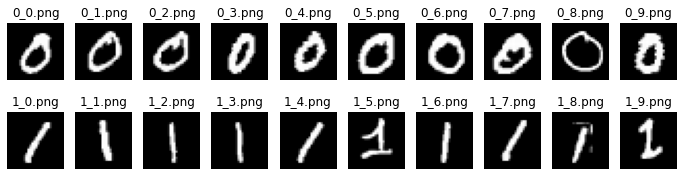

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [263]:
# function to plot multiple images
def plotMultipleImages(nrows, ncols, images, titles, cmap, figsize_x=14, figsize_y=7, suptitle=None):
    fig = plt.figure(figsize=(figsize_x,figsize_y))
    fig.suptitle(t=suptitle, y=0.63)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        if cmap[i]=='rgb':
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap=cmap[i])
        ax.set_title(titles[i])
    plt.show()

### 1.2 Fourier descriptors (15 pts)

Fourier descriptors are a way of encoding the shape of a two-dimensional object by taking the Fourier transform of the boundary, where every  point on the boundary is mapped to a complex number . The original shape can be recovered from the inverse Fourier transform. 

#### 1.2.1 Preprocessing

Input image must be segmented and boundary of the object must be found out before calculating the Fourier Descriptors. Thus, appropriate image preprocessing methods are considered. 
- A low-pass filter should be used to filter out unnecessary informations that may lead to misclassification of numbers. Here, we select the `median filter` due to its main advantages: I) Median filtering preserves sharp contours which are quite important bases in Fourier descriptors, whereas linear low-pass filtering blurs such edges. II) Median filters are very efficient for smoothing of spiky noise.
- We check the histogram distribution of input image and found it is nicely bimodal. The two peaks (intensities of 0 and 255) correspond to the background and handwritten digits, and a few pixels lie in the range between 0 and 255. We then binariz the input images with thresholding to select areas of interest of images (here the digits). Because the input images are in different histrogram ditributions, a global threholding might not be good in all cases. Here, we use `Otsu's method` which determines an optimal global threshold value from the image histogram automatically.
- After that, we use `morphological opening` to remove some white patches caused by residual noise (can be found in 1_8.png).
- Finally, function `find_countours` is used to detect the contours of objects. And the returned value is a list of the coordinates of the contour pixels in order, going **counterclocwise** around the shape.

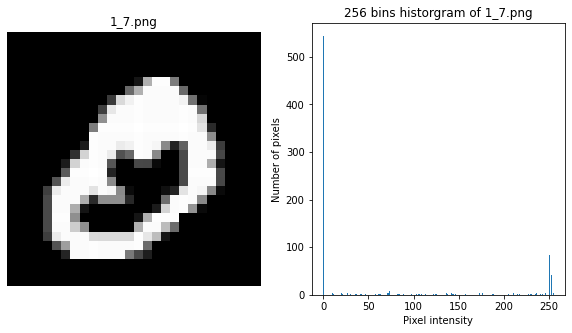

In [199]:
# test image
ind = 7
test_im = zeros_im[ind]
test_im_name = ones_names[ind]

# check the histrogram ditribution
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_im, cmap='gray')
ax[0].set_title(test_im_name)
ax[0].axis('off') 
ax[1].hist(test_im.ravel(), bins=256) 
ax[1].set_title('256 bins historgram of '+test_im_name)
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')
plt.show()

In [246]:
def get_ordered_contour(in_im):
    # a list of the coordinates of the contour pixels (float type)
    contours = measure.find_contours(in_im, 0.8)
    ordered_contour = []
    contour_im = np.zeros(in_im.shape).astype(np.uint8)
    for contour in contours:
        contour = np.rint(contour).astype(np.uint8)
        for x,y in contour:
            ordered_contour.append((x,y))
            contour_im[x,y] = 255
    return np.array(ordered_contour).astype(int), contour_im

def preprocessing(in_im):
    # De-noise
    # median filter with kernel = 1
    median_im = cv.medianBlur(in_im, 1)

    # Image binarization
    # Otsu's thresholding
    _,binary_im = cv.threshold(median_im, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Morphological opening
    morph_im = skimage.morphology.diameter_opening(binary_im,5)
    
    # get the orderred contours
    ordered_contour, contour_im = get_ordered_contour(morph_im)
    
    return median_im, binary_im, morph_im, contour_im, ordered_contour

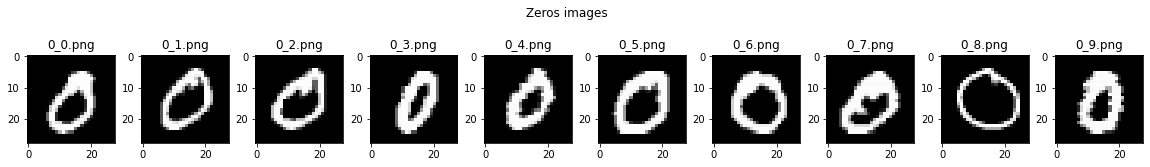

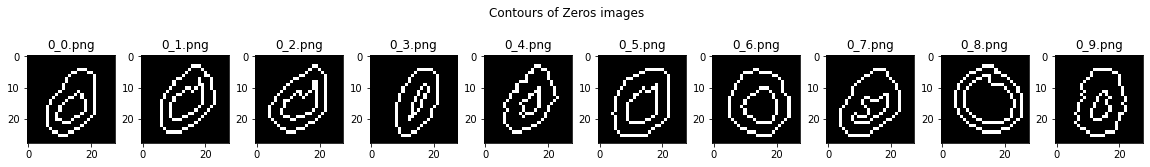

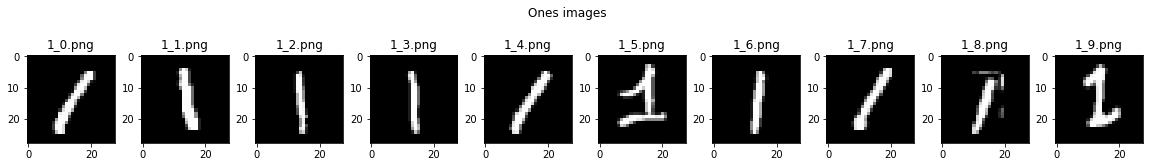

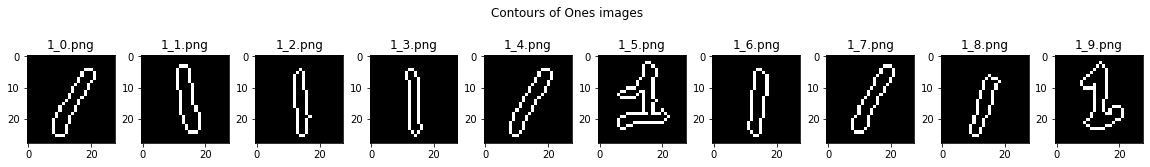

In [266]:
zeros_contour = []
ones_contour = []
zeros_contour_im = np.zeros(zeros_im.shape).astype(np.uint8)
ones_contour_im = np.zeros(ones_im.shape).astype(np.uint8)
for i in range(zeros_im.shape[0]):
    _, _, _, contour_im, ordered_contour = preprocessing(zeros_im[i])
    zeros_contour_im[i] = contour_im
    zeros_contour.append(ordered_contour)
    _, _, _, contour_im, ordered_contour = preprocessing(ones_im[i])
    ones_contour_im[i] = contour_im
    ones_contour.append(ordered_contour)
    
plotMultipleImages(1, 10, zeros_im, zeros_names, cmap=['gray']*10, figsize_x=20, figsize_y=10,suptitle='Zeros images')
plotMultipleImages(1, 10, zeros_contour_im, zeros_names, cmap=['gray']*10, figsize_x=20, figsize_y=10, suptitle='Contours of Zeros images')
plotMultipleImages(1, 10, ones_im, ones_names, cmap=['gray']*10, figsize_x=20, figsize_y=10,suptitle='Ones images')
plotMultipleImages(1, 10, ones_contour_im, ones_names, cmap=['gray']*10, figsize_x=20, figsize_y=10, suptitle='Contours of Ones images')

##### 1.2.2 Implementation of Fourier descriptors

### 1.3 Additional method (5 pts)

In [ ]:
# Add your implementation and discussion

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

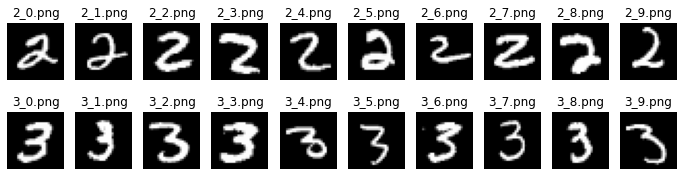

In [4]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [ ]:
# Add your implementation and discussion